In [1]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
building_energy = pd.read_excel("../data/ENB2012_data.xlsx")

In [3]:
feature_names = [
    "Relative Compactness", "Surface Area", "Wall Area", 
    "Roof Area", "Overall Height", "Orientation", 
    "Glazing Area", "Glazing Area Distribution", "Heating Load", 
    "Cooling Load"
]

building_energy.columns = feature_names
building_energy.columns = (building_energy.columns
                           .str.replace(' ', '_')
                           .str.lower()
                        )

building_energy["energy_consumption"] = building_energy[["heating_load", "cooling_load"]].sum(axis=1)

In [4]:
X = building_energy.drop(["heating_load", "cooling_load", "energy_consumption"], axis=1)
y = building_energy["energy_consumption"]

In [5]:
building_energy.describe().T

,count,mean,std,min,25%,50%,75%,max
relative_compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
surface_area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
wall_area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
roof_area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
overall_height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
glazing_area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
glazing_area_distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
heating_load,768.0,22.307195,10.090204,6.01,12.9925,18.95,31.6675,43.10
cooling_load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


In [6]:
building_energy.nunique()

relative_compactness          12
surface_area                  12
wall_area                      7
roof_area                      4
overall_height                 2
orientation                    4
glazing_area                   4
glazing_area_distribution      6
heating_load                 587
cooling_load                 636
energy_consumption           700
dtype: int64

## GP training

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

X_train_scaled = torch.tensor(min_max_scaler.fit_transform(X_train), dtype=torch.float)
before = X_train_scaled.clone().detach()
X_test_scaled = torch.tensor(min_max_scaler.transform(X_test), dtype=torch.float)

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

In [8]:
class GP(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=train_x.shape[1]
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
def fit_model(gp_model, num_iters=100):
    noise = 1e-4
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = gp_model(X_train_scaled, y_train, likelihood)
    model.likelihood.noise = noise
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    loss_hist = []
    for _ in tqdm(range(num_iters)):
        optimizer.zero_grad()
        output = model(X_train_scaled)
        loss = -mll(output, y_train)
        loss_hist.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return model, likelihood, loss_hist

In [10]:
# metrics
# nlpd = gpytorch.metrics.negative_log_predictive_density(predictive_dist, y_test)
# mse = gpytorch.metrics.mean_squared_error(predictive_dist, y_test, squared=True)
# mae = gpytorch.metrics.mean_absolute_error(predictive_dist, y_test)

Setting the bounds for the domain (search space) requires prior knowledge about the problem. 

It may not be desireable to set the lower and upper bound to the empirical min and max if it is possible to have values outside of these ranges. Doing so may restrict the domain, and thus the co-domain.

Additionally, bounds may be set that are according to technical specifications. For example, belt speed, cutting angle, etc.

In [11]:
df_ = pd.DataFrame(X_train_scaled.numpy())
df_.columns = X_train.columns
df_.describe().T

,count,mean,std,min,25%,50%,75%,max
relative_compactness,537.0,0.000000e+00,1.000932,-1.394777,-0.725177,-0.055577,0.518365,2.048879
surface_area,537.0,-1.775930e-08,1.000932,-1.790930,-0.661808,-0.097247,0.749594,1.596435
wall_area,537.0,0.000000e+00,1.000932,-1.693706,-0.579781,-0.022818,0.534145,2.205034
roof_area,537.0,-9.767614e-09,1.000932,-1.439275,-1.167895,-0.625134,1.003146,1.003146
overall_height,537.0,7.103719e-09,1.000932,-1.032175,-1.032175,0.968828,0.968828,0.968828
orientation,537.0,1.775930e-08,1.000932,-1.346642,-0.459345,-0.459345,1.315248,1.315248
glazing_area,537.0,-2.930284e-08,1.000932,-1.804237,-1.050249,0.080734,1.211717,1.211717
glazing_area_distribution,537.0,-7.103719e-09,1.000932,-1.909593,-0.601619,0.052368,0.706354,1.360341


In [12]:
# std scaler bounds
# bounds = torch.tensor(
#     [
#         [-5, -5, -5, -5, -5, -5, -5, -5],
#         [5, 5, 5, 5, 5, 5, 5, 5],
#     ],
#     dtype=torch.float,
# )

In [10]:
# min_max bounds
bounds = torch.tensor(
    [
        [-2, -2, -2, -2, -2, -2, -2, -2],
        [2, 2, 2, 2, 2, 2, 2, 2],
    ],
    dtype=torch.float,
)

In [11]:
# BayesOpt: minimize the objective function --> .min()
num_iters = 100
num_queries = 10
for i in range(num_queries):
    print("-"*20)
    print(f"iteration: {i}")
    print(f"incumbent: {X_train_scaled[y_train.argmin()]}, obj. func. value: {y_train.min():.4f}")

    model, likelihood, loss_hist = fit_model(GP, num_iters)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
            model, best_f=y_train.min()
        )

    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=20*8,
        raw_samples=50*8
    )

    # evaluate the objective function and update training data
    with torch.no_grad():
        predictive_dist = likelihood(model(next_x))
        next_y_mean = predictive_dist.mean
        # predictive_upper, predictive_lower = predictive_dist.confidence_region()
    
    X_train_scaled = torch.cat([X_train_scaled, next_x])
    y_train = torch.cat([y_train, next_y_mean])

--------------------
iteration: 0
incumbent: tensor([0.3333, 0.5833, 0.0000, 1.0000, 0.0000, 0.6667, 0.0000, 0.0000]), obj. func. value: 16.9500


100%|██████████| 100/100 [00:00<00:00, 158.10it/s]


--------------------
iteration: 1
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 161.33it/s]


--------------------
iteration: 2
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 156.46it/s]


--------------------
iteration: 3
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 166.78it/s]


--------------------
iteration: 4
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 162.28it/s]


--------------------
iteration: 5
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 154.98it/s]


--------------------
iteration: 6
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 156.18it/s]


--------------------
iteration: 7
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 175.54it/s]


--------------------
iteration: 8
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 160.47it/s]


--------------------
iteration: 9
incumbent: tensor([ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844]), obj. func. value: 7.7533


100%|██████████| 100/100 [00:00<00:00, 155.41it/s]


In [21]:
model.covar_module.base_kernel.lengthscale

tensor([[0.1961, 0.1992, 0.2057, 0.3161, 0.2977, 0.4436, 0.6264, 0.2457]],
       grad_fn=<SoftplusBackward0>)

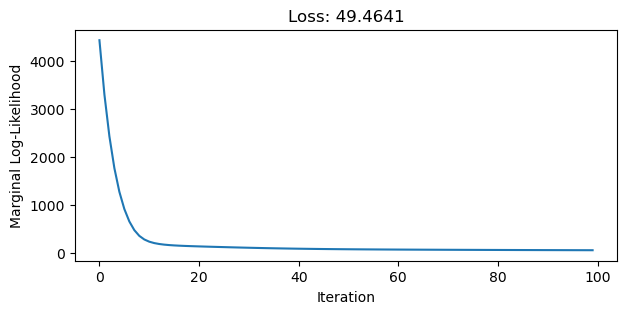

In [22]:
plt.figure(figsize=(7, 3))
plt.plot(torch.arange(len(loss_hist)), loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Marginal Log-Likelihood")
plt.title(f"Loss: {loss_hist[-1]:.4f}");

In [23]:
minimizing_features = pd.DataFrame(X_train_scaled.numpy()[y_train.argmin()]).T
minimizing_features.columns = list(X_train.columns)
minimizing_features["objective_value"] = y_train.min().item()

In [24]:
minimizing_features

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,objective_value
0,0.722426,0.497718,0.911004,1.352464,0.843402,0.650295,-0.242757,0.984442,7.753261


In [18]:
data_added = X_train_scaled[-10:]
data_added

tensor([[ 0.7224,  0.4977,  0.9110,  1.3525,  0.8434,  0.6503, -0.2428,  0.9844],
        [ 0.4277,  0.3942,  0.7922,  0.7195,  0.7890, -0.1481,  0.4162,  0.3790],
        [ 0.7351,  0.2994,  0.2244,  0.2561,  1.0265,  1.1110,  1.3259,  0.2174],
        [ 0.7793, -0.0322,  0.2384,  0.2080,  1.2789,  1.3362, -0.1387,  0.8613],
        [ 0.7076,  0.6330,  0.7879,  0.4467,  0.9706,  0.2149,  1.4057,  0.2235],
        [ 0.2241,  0.7274,  0.1543,  0.6231,  0.0330,  0.9151,  1.7172,  0.4568],
        [ 0.6142,  0.1395,  0.3768,  0.2519,  1.0876, -0.1039, -0.9508,  0.0899],
        [ 0.4709,  0.2497,  0.3812,  0.0208,  0.6736,  0.0534,  0.7180,  0.6096],
        [ 0.6726,  0.3353,  0.3330,  0.5973,  1.0169, -0.4700,  0.9339,  0.1384],
        [ 0.3751,  0.4705,  0.9443,  0.0949,  1.0007, -0.1496, -0.0461,  0.0207]])

In [27]:
min_max_scaler.transform(minimizing_features.iloc[:, :-1])

array([[ 0.28451717, -1.7483071 , -1.4232595 , -0.98773277, -0.7590281 ,
        -0.44990158, -0.6068915 ,  0.1968884 ]], dtype=float32)

## Dimensionality of grid predictions

Computational complexity $\mathcal{O}$ depends on the number of dimensions and the grandularity of the linspace.

In [65]:
grid_x = torch.linspace(0, 1, 50)
grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [66]:
grid_x1.shape, grid_x2.shape, xs.shape

(torch.Size([50, 50]), torch.Size([50, 50]), torch.Size([2500, 2]))

In [67]:
50**2 # 2,500 rows and 2 dimensions (columns)

2500

In [50]:
grid_x = torch.linspace(0, 1, 10) # ONLY 10 points
grid_1, grid_2, grid_3, grid_4, grid_5, grid_6, grid_7, grid_8 = torch.meshgrid(
    [grid_x, grid_x, grid_x, grid_x, grid_x, grid_x, grid_x, grid_x], 
    indexing='ij'
)

In [68]:
grid_1.shape, grid_1.flatten().shape

(torch.Size([10, 10, 10, 10, 10, 10, 10, 10]), torch.Size([100000000]))

In [69]:
10**8 # 100 million rows and 8 dimensions (columns)

100000000